# Прогнозирование температуры плавления стали

Металлургический комбинат **«Стальная птица»** стремится оптимизировать производственные расходы за счёт снижения потребления электроэнергии на этапе обработки стали. Для достижения этой цели необходимо обеспечить эффективный контроль температуры сплава. В рамках проекта требуется разработать модель, которая будет её предсказывать.

---

**Описание этапа обработки стали.**  

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).  

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

---

**Описание данных**

`data_arc_new.csv` — данные об электродах:  
- `key` — номер партии;  
- `Начало нагрева дугой` — время начала нагрева;  
- `Конец нагрева дугой` — время окончания нагрева;  
- `Активная мощность` — значение активной мощности;  
- `Реактивная мощность` — значение реактивной мощности.  

`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):  
- `key` — номер партии;  
- `Bulk 1 … Bulk 15` — объём подаваемого материала.  

`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):  
- `key` — номер партии;  
- `Bulk 1 … Bulk 15` — время подачи материала.  

`data_gas_new.csv`— данные о продувке сплава газом:  
- `key` — номер партии;  
- `Газ 1` — объём подаваемого газа.  

`data_temp_new.csv` — результаты измерения температуры:  
- `key` — номер партии;  
- `Время замера` — время замера;  
- `Температура` — значение температуры.  

`data_wire_new.csv` — данные о проволочных материалах (объём):  
- `key` — номер партии;  
- `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.    

`data_wire_time_new.csv` — данные о проволочных материалах (время):  
- `key` — номер партии;  
- `Wire 1 … Wire 9` — время подачи проволочных материалов.  


---


**Цель исследования:**  
Разработать модель для прогнозирования температуры сплава на этапе обработки стали.  

**План исследования:**  
- *Предобработка данных*  
  Изучить общую информацию о данных, выявить и устранить проблемы  
- *Исследовательский анализ данных*  
  Проанализировать распределение признаков, при необходимости обработать выбросы, аномальные значения и т.д.  
- *Подготовка признаков и интпеграция данных*  
  Создать дополнительные признаки, объединить данные, проанализировать финальный датафрейм  
- *Обучение моделей*  
  Разделить данные на обучающую и тестовую выборки, обучить модели, выбрать оптимальную, интерпретировать  
- *Оценить точность модели*  
  Протеристировать лучшую модель на тестовой выборке и сравнить с критерием качества  
- *Сделать вывод по результатам работы*

---

***Критерий оценки: MAE <= 6.8***

## Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 10725

In [ ]:
try:
    df_arc = pd.read_csv('data_arc_new.csv',
                         parse_dates=['Начало нагрева дугой',
                                      'Конец нагрева дугой'])
    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv',
                               parse_dates=[f'Bulk {x}' for x in range(1, 16)])
    df_gas = pd.read_csv('data_gas_new.csv')
    df_temp = pd.read_csv('data_temp_new.csv',
                          parse_dates=['Время замера'])
    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_time = pd.read_csv('data_wire_time_new.csv',
                               parse_dates=[f'Wire {x}' for x in range(1, 10)])
except:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv',
                         parse_dates=['Начало нагрева дугой',
                                      'Конец нагрева дугой'])
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv',
                               parse_dates=[f'Bulk {x}' for x in range(1, 16)])
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv',
                          parse_dates=['Время замера'])
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv',
                               parse_dates=[f'Wire {x}' for x in range(1, 10)])

Определим функцию для вывода основной информации о датасете

In [ ]:
def data_info(df):
    display(df.head())
    print()
    df.info()
    print()
    print('Количество явных дубликатов:', df.duplicated().sum())
    print()
    print('Количество пропущенных значений:\n', df.isna().sum())

In [ ]:
for df, df_name in [[df_arc, 'data_arc'],
                    [df_bulk, 'data_bulk'],
                    [df_bulk_time, 'data_bulk_time'],
                    [df_gas, 'data_gas'],
                    [df_temp, 'data_temp'],
                    [df_wire, 'data_wire'],
                    [df_wire_time, 'data_wire_time']]:
    print('Набор данных:', df_name)
    print()
    data_info(df)
    print()

Набор данных: data_arc



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Набор данных: data_bulk



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5  

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB

Количество явных дубл

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key      0
Газ 1    0
dtype: int64

Набор данных: data_temp



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key                0
Время замера       0
Температура     3427
dtype: int64

Набор данных: data_wire



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Набор данных: data_wire_time



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64



**Промежуточный вывод**

В датасетах `df_bulk`, `df_bulk_time`, `df_temp`, `df_wire` и `df_wire_time` есть пропущенные значения, для дальнейшей работы необходимо будет их обработать. Также, потребуется привести названия столбцов во всех датафреймах к общему виду и проверить типы данных в `df_bulk` и `df_temp`, при необходимости привести их к типу `int`.

## Предобработка данных

### Переименование признаков

Начнём с наименований признаков: для удобства дальнейшей работы запишем их латиницей

In [ ]:
df_arc.columns = ['key', 'start_heat_time', 'end_heat_time', 'active_power', 'reactive_power']
df_gas.columns = ['key', 'gas_1']
df_temp.columns = ['key', 'temp_time', 'temp']

Названия столбцов в `df_bulk`, `df_bulk_time`, `df_wire` и `df_wire_time` приведём к змеиному регистру

In [ ]:
for df in [df_bulk,
           df_bulk_time,
           df_wire,
           df_wire_time]:
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.lower()

In [ ]:
df

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
df_wire_time

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
df_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


### Обработка пропущенных значений

Так как `df_bulk` и `df_wire`, содержат большое количество пропусков, удалять эти наблюдения не стоит. Однако из описания данных известно, что признаки в этих датафреймах отражают объём подаваемых сыпучих и проволочных материалов, поэтому пропущенные значения могут свидетельствовать о том, что тот или иной материал просто не подавался на данном этапе обработки, а значит - целесообразно заполнить эти значения нулями.  
Так как признак `temp` в данном случае является целевым, наблюдения с пропусками по нему лучше удалить, поскольку заполнение NaN-значений может исказить результаты моделирования.

In [ ]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)
key_nan = df_temp.loc[df_temp['temp'].isna(), 'key'].unique()
df_temp = df_temp[~df_temp['key'].isin(key_nan)]

## df_temp

### Корректировка типов данных

По первичному обзору данных можно сделать предположения, что признаки `bulk_1` - `bulk_15` и `temp` с типом данных `float` на самом деле содержат только целые числа. Проверим, так ли это:

In [ ]:
bulk_int_cols = []

for col in df_bulk.select_dtypes(include=['float']).columns:
    # Проверяем, являются ли значения целочисленными
    if df_bulk[col].apply(lambda x: x.is_integer()).all():
        bulk_int_cols.append(col)

print("Столбцы в data_bulk с типом данных float, содержащие только целые числа:")
print(bulk_int_cols)

Столбцы в data_bulk с типом данных float, содержащие только целые числа:
['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']


In [ ]:
if df_temp['temp'].apply(lambda x: x.is_integer()).all():
    print("Признак 'temp' содержит только целые числа")

Признак 'temp' содержит только целые числа


Гипотеза подтвердилась, а значит можно привести их к типу `int` для экономии памяти и оптимизации дальнейшей обработки

In [ ]:
df_temp['temp'] = df_temp['temp'].astype(int)

for col in bulk_int_cols:
    df_bulk[col] = df_bulk[col].astype(int)

Повторно выведем общую информацию о наборах данных уже после предобработки

In [ ]:
for df, df_name in [[df_arc, 'data_arc'],
                    [df_bulk, 'data_bulk'],
                    [df_bulk_time, 'data_bulk_time'],
                    [df_gas, 'data_gas'],
                    [df_temp, 'data_temp'],
                    [df_wire, 'data_wire'],
                    [df_wire_time, 'data_wire_time']]:
    print('Набор данных:', df_name)
    print()
    data_info(df)
    print()

Набор данных: data_arc



,key,start_heat_time,end_heat_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              14876 non-null  int64         
 1   start_heat_time  14876 non-null  datetime64[ns]
 2   end_heat_time    14876 non-null  datetime64[ns]
 3   active_power     14876 non-null  float64       
 4   reactive_power   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key                0
start_heat_time    0
end_heat_time      0
active_power       0
reactive_power     0
dtype: int64

Набор данных: data_bulk



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_2   3129 non-null   int64
 3   bulk_3   3129 non-null   int64
 4   bulk_4   3129 non-null   int64
 5   bulk_5   3129 non-null   int64
 6   bulk_6   3129 non-null   int64
 7   bulk_7   3129 non-null   int64
 8   bulk_8   3129 non-null   int64
 9   bulk_9   3129 non-null   int64
 10  bulk_10  3129 non-null   int64
 11  bulk_11  3129 non-null   int64
 12  bulk_12  3129 non-null   int64
 13  bulk_13  3129 non-null   int64
 14  bulk_14  3129 non-null   int64
 15  bulk_15  3129 non-null   int64
dtypes: int64(16)
memory usage: 391.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_1

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB

Количество явных дубл

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key      0
gas_1    0
dtype: int64

Набор данных: data_temp



,key,temp_time,temp
0,1,2019-05-03 11:02:04,1571
1,1,2019-05-03 11:07:18,1604
2,1,2019-05-03 11:11:34,1618
3,1,2019-05-03 11:18:04,1601
4,1,2019-05-03 11:25:59,1606



<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13926 non-null  int64         
 1   temp_time  13926 non-null  datetime64[ns]
 2   temp       13926 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 435.2 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key          0
temp_time    0
temp         0
dtype: int64

Набор данных: data_wire



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Набор данных: data_wire_time



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Количество явных дубликатов: 0

Количество пропущенных значений:
 key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64



### Промежуточный вывод

В ходе предобработки данных были выполнены следующие шаги:  
- переименованы столбцы датафреймов,  
- обработаны пропущенные значения,  
- скорректированы типы данных (целочисленные признаки приведены к типу `int`).  

Можно приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

Определим функцию для визуализации распределенний признаков и вывода описательной статистики

In [ ]:
# Визуализация количественных признаков и вывод описательной статистики
def num_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Гистограмма
    sns.histplot(x=feature, kde=True, ax=ax[0])
    ax[0].set_title('Распределение данных')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)

    # Диаграмма размаха
    sns.boxplot(x=feature, ax=ax[1])
    ax[1].set_title('Диаграмма размаха')
    ax[1].set_xlabel(feature_name)
    ax[1].grid(True)

    plt.show()

    print()
    print('Описательная статистика')
    print(feature.describe())

### Активная мощность

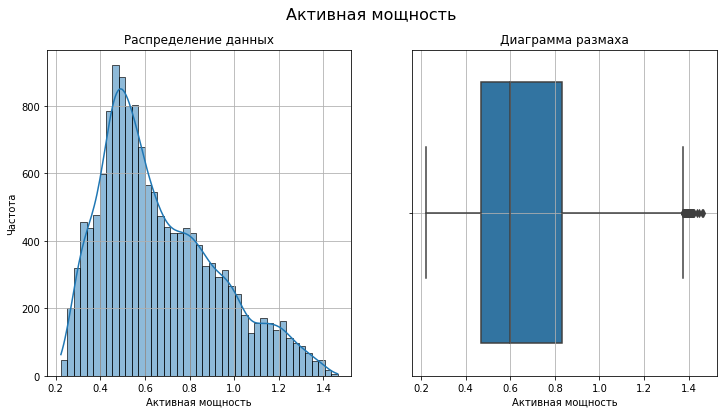


Описательная статистика
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64


In [ ]:
num_features_stats(df_arc['active_power'],
                   'Активная мощность',
                   'Активная мощность')

Данные об активной мощности содержат выбросы, однако эти значений явно не являются аномальными и имеют не очень большой разброс. Так как данный показатель вполне может принимать такие значения, оставим его без изменений.

### Реактивная мощность

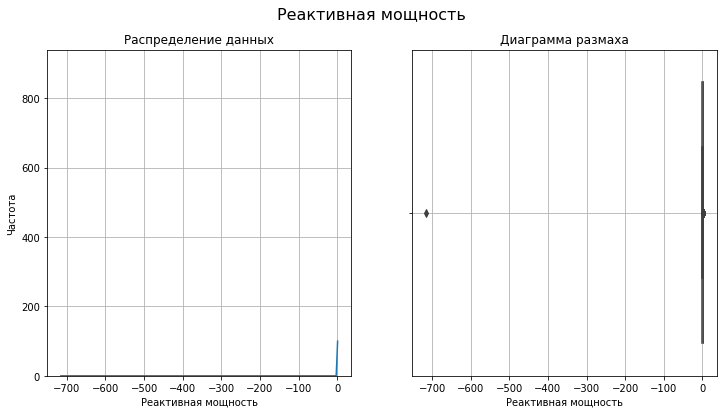


Описательная статистика
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


In [ ]:
num_features_stats(df_arc['reactive_power'],
                   'Реактивная мощность',
                   'Реактивная мощность')

In [ ]:
df_arc[df_arc['reactive_power'] < -100]

,key,start_heat_time,end_heat_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


А вот реактивная мощность -715,5 явно не является нормой, это наблюдение смело можно удалить и построить графики распределения повторно

In [ ]:
key_to_drop = df_arc.loc[df_arc['reactive_power'] < -100, 'key']
df_arc = df_arc[~df_arc['key'].isin(key_to_drop)]

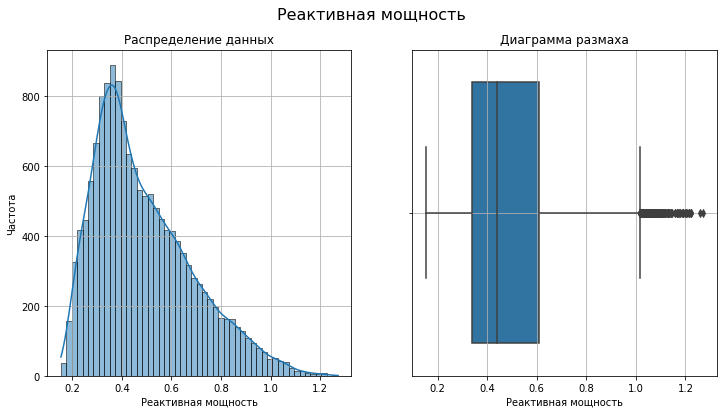


Описательная статистика
count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


In [ ]:
num_features_stats(df_arc['reactive_power'],
                   'Реактивная мощность',
                   'Реактивная мощность')

Распределение близко к нормальному со смещением влево, так же есть выбросы, но они находятся в пределах допустимых значений, не будем их удалять, чтобы модель обучалась на разных данных и могла учитывать разные случаи.

### Объём сыпучих материалов

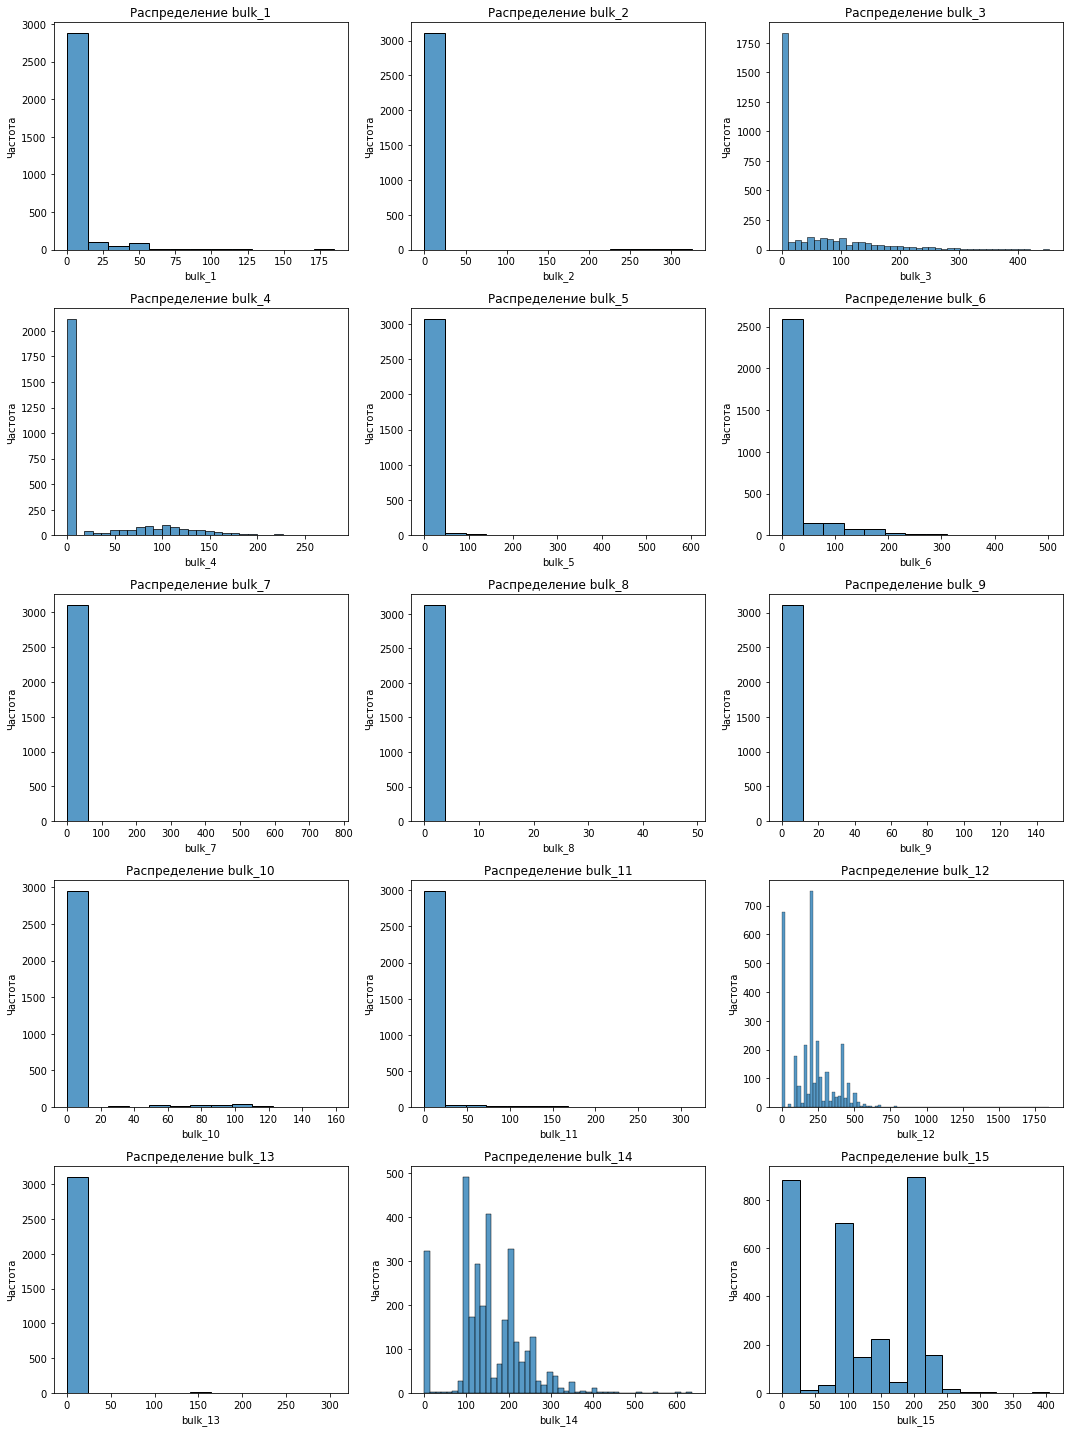

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))
ax = ax.flatten()

for i, col in enumerate(df_bulk.columns[1:]):
    sns.histplot(df_bulk[col], ax=ax[i])
    ax[i].set_title(f'Распределение {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

In [ ]:
df_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Наличие большого количества нулей в признаках `bulk_1` - `bulk_15`, искажает визуализацию распределений и делает их сложными для восприятия. Построим аналогичные гистограммы только для ненулевых значений:

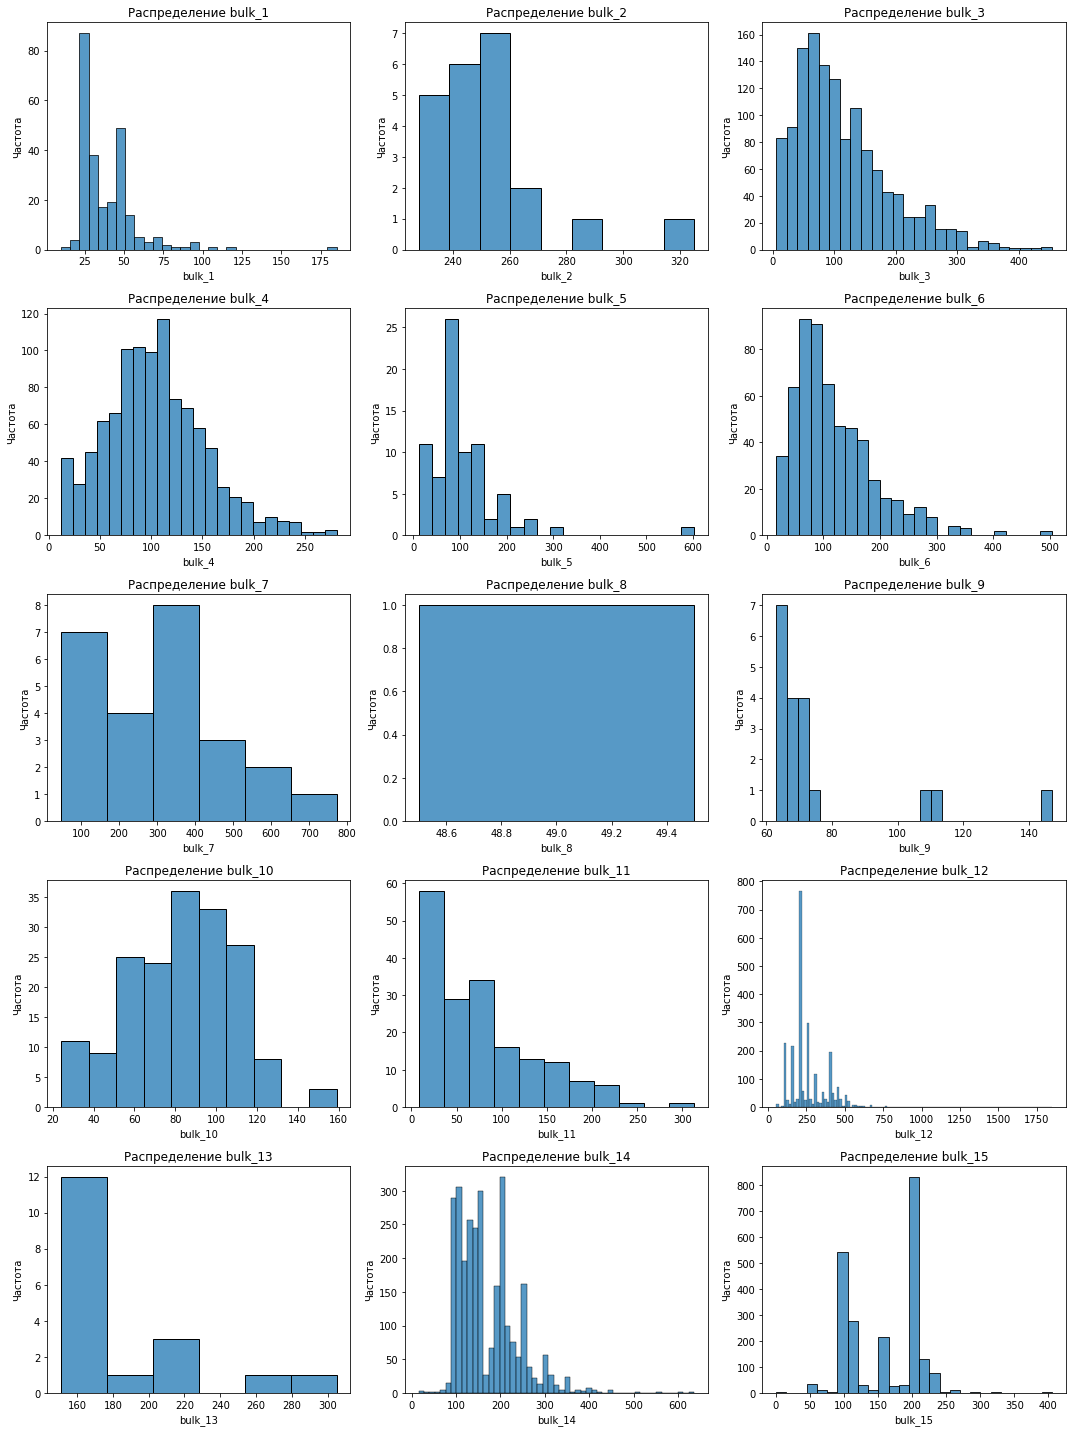

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))
ax = ax.flatten()

for i, col in enumerate(df_bulk.columns[1:]):
    sns.histplot(df_bulk[col][df_bulk[col] != 0], ax=ax[i])
    ax[i].set_title(f'Распределение {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

In [ ]:
df_bulk['bulk_8'].value_counts()

0     3128
49       1
Name: bulk_8, dtype: int64

Гистограммы позволили обнаружить неинформативный столбец `bulk_8`, содержащий лишь одно ненулевое значение, можно его удалить

In [ ]:
df_bulk = df_bulk.drop(columns='bulk_8')

### Объём подаваемого газа

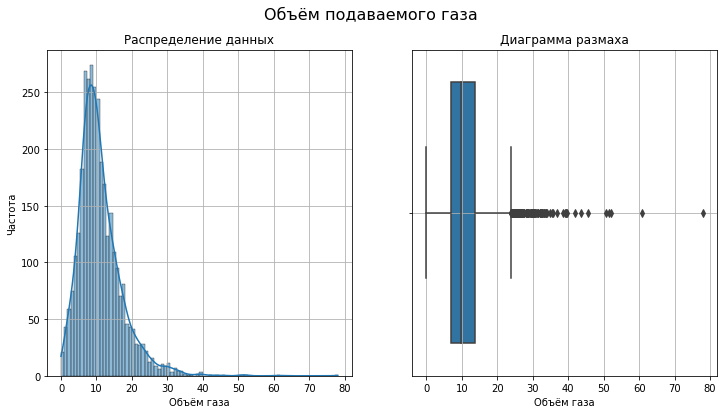


Описательная статистика
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64


In [ ]:
num_features_stats(df_gas['gas_1'],
                   'Объём газа',
                   'Объём подаваемого газа')

Данные об объёме подаваемого газа также содержат выбросы, но их пока оставим без изменений

### Объём проволочных материалов

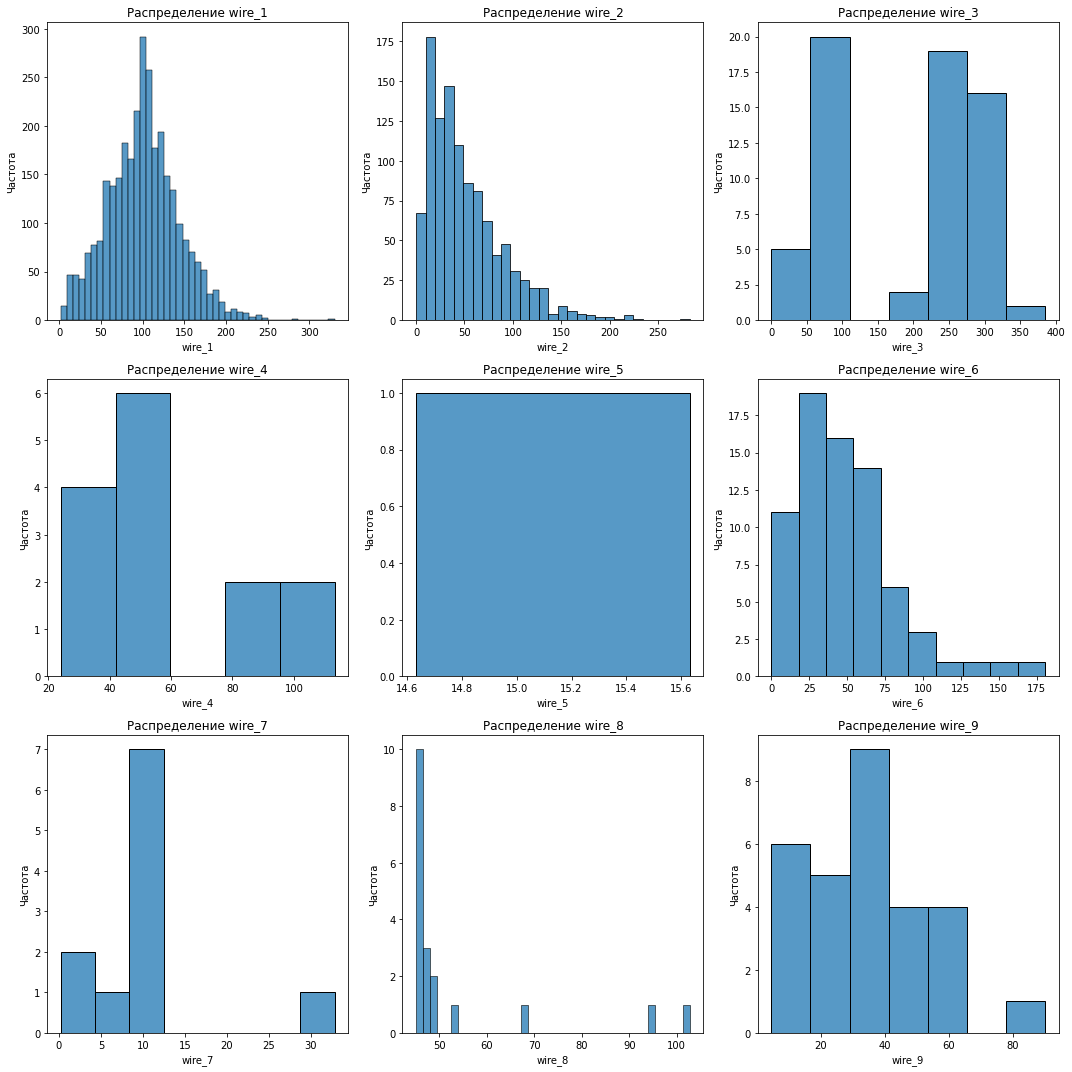

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

for i, col in enumerate(df_wire.columns[1:]):
    sns.histplot(df_wire[col][df_wire[col] != 0], ax=ax[i])
    ax[i].set_title(f'Распределение {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Столбец `wire_5` является неиформативным, как и `bulk_8` ранее, целесообразно удалить его.

In [ ]:
df_wire = df_wire.drop(columns='wire_5')

### Температура (целевой признак)

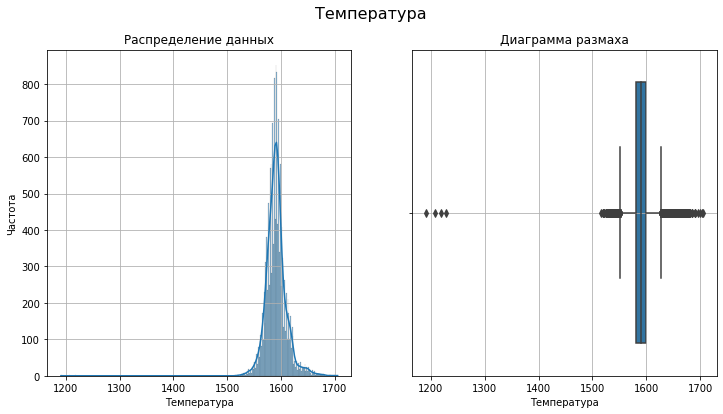


Описательная статистика
count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


In [ ]:
num_features_stats(df_temp['temp'],
                   'Температура',
                   'Температура')

Значения температуры ниже 1 300 похожи на аномальные значения, сильно выбивающиеся из основного распределения. Оценим их количество:

In [ ]:
df_temp.query('temp < 1300')

,key,temp_time,temp
4883,867,2019-06-06 08:03:39,1191
6784,1214,2019-06-18 08:01:03,1208
9050,1619,2019-07-03 02:34:41,1218
11495,2052,2019-07-25 08:49:15,1227


5 наблюдений из 14 665 находятся далеко за пределами межквартильного размаха, к тому же - по информации из интернета температура плавления стали (хоть и различается в зависимости от вида стали) в основном составляет не менее 1 400 градусов. Удалим эти наблюдения как аномалии.

In [ ]:
key_to_drop = df_temp.loc[df_temp['temp'] < 1300, 'key']
df_temp = df_temp[~df_temp['key'].isin(key_to_drop)]

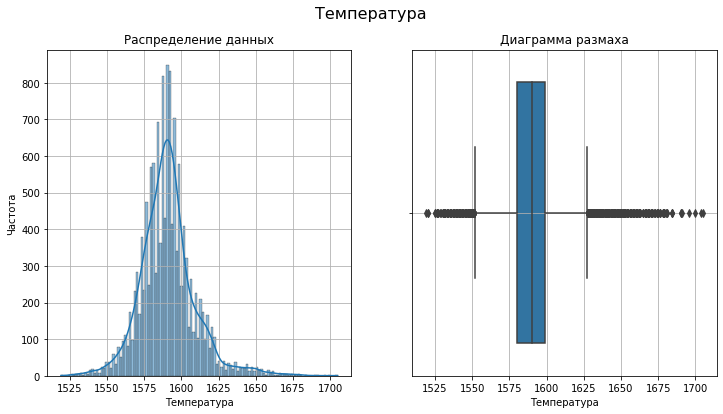


Описательная статистика
count    13905.000000
mean      1590.924847
std         18.750314
min       1519.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


In [ ]:
num_features_stats(df_temp['temp'],
                   'Температура',
                   'Температура')

Теперь распределение близко к нормальному.

### Промежуточный вывод

В ходе исследовательского анализа данных были обработаны аномальные значения и удалены неинформативные признаки. Признаки по большей части имеют распределение, близкое к нормальному, однако по-прежнему содержат выбросы, а значит - при обучении моделей необходимо будет масштабировать данные.

## Подготовка данных и создание признаков

### Отбор подходящих партий

Прежде чем приступать к объединению данных, определим партии, для которых известны как начальные, так и конечные значения температуры. Партии с единстенным замером температуры нам не подходят

In [ ]:
key_to_drop = []

for key in list(df_temp['key'].unique()):
    if ((df_temp[df_temp['key'] == key]['temp_time'].min() >
         df_arc[df_arc['key'] == key]['start_heat_time'].min())
        or (df_temp[df_temp['key'] == key]['temp_time'].max() <
            df_arc[df_arc['key'] == key]['end_heat_time'].max())
        or (df_temp[df_temp['key'] == key]['temp_time'].min() ==
            df_temp[df_temp['key'] == key]['temp_time'].max())):
            key_to_drop.append(key)

print('Доля партий, не удовлетворяющих условию:')
print(round((len(key_to_drop)/len(df_temp['key'].unique())*100),2),'%')

Доля партий, не удовлетворяющих условию:
0.08 %


In [ ]:
df_temp = df_temp.query('key not in @key_to_drop')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13903 non-null  int64         
 1   temp_time  13903 non-null  datetime64[ns]
 2   temp       13903 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 434.5 KB


### Выделение целевой переменной

Так как предсказывать предстоит именно последний замер, разделим признак `temp` на начальную и конечную температуру:

In [ ]:
results = []

for key in df_temp['key'].unique():
    min_temp_time = df_temp[df_temp['key'] == key]['temp_time'].min()
    max_temp_time = df_temp[df_temp['key'] == key]['temp_time'].max()

    first_temp = df_temp.query(
        'key == @key and temp_time == @min_temp_time'
        )['temp'].iloc[0]

    last_temp = df_temp.query(
        'key == @key and temp_time == @max_temp_time'
        )['temp'].iloc[0]

    result = {
        'key': key,
        'first_temp': first_temp,
        'last_temp': last_temp
    }

    results.append(result)

# Создаем итоговый DataFrame из списка результатов
df_temp_total = pd.DataFrame(results)
df_temp_total = df_temp_total.set_index('key')

In [ ]:
df_temp_total

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602
...,...,...
2495,1570,1591
2496,1554,1591
2497,1571,1589


`last_temp` будет выступать в качестве таргета, а `first_temp` можно использовать как входной признак.

### Создание дополнительных признаков

<div style="background-color: lavender; border: 2px solid purple; border-radius: 5px; padding: 10px">
    <p>Здесь добавила новый признак - длительность нагрева дугой (heat_duration)</p>
</div>

Добавим в датасет `df_arc` длительность нагрева дугой

In [ ]:
df_arc['heat_duration'] = (
    df_arc['end_heat_time'] - df_arc['start_heat_time']
    ).dt.total_seconds()
df_arc.head(10)

,key,start_heat_time,end_heat_time,active_power,reactive_power,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


Сгруппируем данные по партиям и рассчитаем суммарные и средние значения активной и реактивной мощностей, а также определим суммарную длительность нагрева

In [ ]:
df_arc_total = pd.pivot_table(df_arc,
                              index='key',
                              values=['active_power',
                                      'reactive_power',
                                      'heat_duration'],
                             aggfunc={
                                  'active_power': ['sum', 'mean'],
                                  'reactive_power': ['sum', 'mean'],
                                  'heat_duration': 'sum'
                                  })
df_arc_total

active_power           heat_duration reactive_power          
             mean       sum           sum           mean       sum
key                                                               
1        0.607346  3.036730        1098.0       0.428564  2.142821
2        0.534852  2.139408         811.0       0.363339  1.453357
3        0.812728  4.063641         655.0       0.587491  2.937457
4        0.676622  2.706489         741.0       0.514248  2.056992
5        0.563238  2.252950         869.0       0.421998  1.687991
...           ...       ...           ...            ...       ...
3237     0.508374  2.541872         909.0       0.405083  2.025417
3238     0.458274  1.374821         546.0       0.346034  1.038103
3239     0.606001  4.848005        1216.0       0.442693  3.541541
3240     0.663536  3.317679         839.0       0.474710  2.373552
3241     0.609057  3.045283         659.0       0.428002  2.140011

[3213 rows x 5 columns]

In [ ]:
df_arc_total.columns = ['mean_active_power',
                        'sum_active_power',
                        'sum_heat_duration',
                        'mean_reactive_power',
                        'sum_reactive_power']

df_arc_total

,mean_active_power,sum_active_power,sum_heat_duration,mean_reactive_power,sum_reactive_power
key,,,,,
1,0.607346,3.036730,1098.0,0.428564,2.142821
2,0.534852,2.139408,811.0,0.363339,1.453357
3,0.812728,4.063641,655.0,0.587491,2.937457
4,0.676622,2.706489,741.0,0.514248,2.056992
5,0.563238,2.252950,869.0,0.421998,1.687991
...,...,...,...,...,...
3237,0.508374,2.541872,909.0,0.405083,2.025417
3238,0.458274,1.374821,546.0,0.346034,1.038103
3239,0.606001,4.848005,1216.0,0.442693,3.541541


<div style="background-color: lavender; border: 2px solid purple; border-radius: 5px; padding: 10px">
    <p>И ещё один новый признак:</p>
</div>

Также, можно сгенерировать длительность последнего нагрева дугой:

In [ ]:
# Для каждой партии выделяем наблюдения о последнем нагреве
idx_last_heat = df_arc.groupby('key')['end_heat_time'].idxmax()
df_last_heat = df_arc.loc[idx_last_heat, ['key',
                                          'start_heat_time',
                                          'end_heat_time']].copy()
df_last_heat.head()

,key,start_heat_time,end_heat_time
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18
13,3,2019-05-03 12:31:14,2019-05-03 12:32:19
17,4,2019-05-03 12:53:12,2019-05-03 12:57:50
21,5,2019-05-03 13:32:44,2019-05-03 13:33:55


In [ ]:
# Считаем длительность нагрева в секундах
df_last_heat['last_heat_duration'] = (
    df_last_heat['end_heat_time'] - df_last_heat['start_heat_time']
    ).dt.total_seconds()
df_last_heat = df_last_heat.drop(columns=['start_heat_time',
                                          'end_heat_time'])
df_last_heat.head()

,key,last_heat_duration
4,1,148.0
8,2,210.0
13,3,65.0
17,4,278.0
21,5,71.0


Поличили следующие признаки:  
- суммарная активная мощность,  
- суммарная реактивная мощность,  
- средняя активная мощность,  
- средняя реактивная мощность,  
- суммарная длительность нагрева дугой,  
- длительность последнего нагрева дугой

Также, можно рассчитать общий объём сыпучих материалов на партию:

In [ ]:
df_bulk = df_bulk.set_index('key')
df_bulk['sum_bulk'] = df_bulk.sum(axis=1)

df_bulk

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
key,,,,,,,,,,,,,,,
1,0,0,0,43,0,0,0,0,0,0,206,0,150,154,553
2,0,0,0,73,0,0,0,0,0,0,206,0,149,154,582
3,0,0,0,34,0,0,0,0,0,0,205,0,152,153,544
4,0,0,0,81,0,0,0,0,0,0,207,0,153,154,595
5,0,0,0,78,0,0,0,0,0,0,203,0,151,152,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0,0,170,0,0,0,0,0,0,0,252,0,130,206,758
3238,0,0,126,0,0,0,0,0,0,0,254,0,108,106,594
3239,0,0,0,0,0,114,0,0,0,0,158,0,270,88,630


Аналогично для проволочных материалов:

In [ ]:
df_wire = df_wire.set_index('key')
df_wire['sum_wire'] = df_wire.sum(axis=1)

df_wire

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,sum_wire
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,143.357761


### Промежуточный вывод

В ходе подготовки данных были отобраны партии, имеющие как минимум 2 замера температуры: до начала нагрева дугой и после окончания нагрева. Помимо этого была выделена целевая переменная и созданы дополнительные признаки, такие как:  
- суммарная активная мощность,  
- суммарная реактивная мощность,  
- средняя активная мощность,  
- средняя реактивная мощность,
- суммарный объём подаваемых сыпучих материалов,  
- суммарный объём проволочных материалов,  
- первый замер температуры,  
- суммарная длительность нагрева дугой,  
- длительность последнего нагрева.

## Объединение данных

Теперь необходимо объединить данные.  
Чтобы в итоговый датафрейм вошли наблюдения только по тем партиям, которые есть во всех датасетах, воспользуемся объединением inner join

In [ ]:
df_gas = df_gas.set_index('key')
df_last_heat = df_last_heat.set_index('key')

In [ ]:
df = (df_temp_total.merge(
    df_arc_total, left_index=True, right_index=True, how='inner')
    .merge(df_last_heat, left_index=True, right_index=True, how='inner')
    .merge(df_bulk, left_index=True, right_index=True, how='inner')
    .merge(df_wire, left_index=True, right_index=True, how='inner')
    .merge(df_gas, left_index=True, right_index=True, how='inner'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_temp           2324 non-null   int64  
 1   last_temp            2324 non-null   int64  
 2   mean_active_power    2324 non-null   float64
 3   sum_active_power     2324 non-null   float64
 4   sum_heat_duration    2324 non-null   float64
 5   mean_reactive_power  2324 non-null   float64
 6   sum_reactive_power   2324 non-null   float64
 7   last_heat_duration   2324 non-null   float64
 8   bulk_1               2324 non-null   int64  
 9   bulk_2               2324 non-null   int64  
 10  bulk_3               2324 non-null   int64  
 11  bulk_4               2324 non-null   int64  
 12  bulk_5               2324 non-null   int64  
 13  bulk_6               2324 non-null   int64  
 14  bulk_7               2324 non-null   int64  
 15  bulk_9               2324 non-null   i

## Анализ объединенного датафрейма

### Исследовательский анализ

Визуализируем распределения признаков после объединения

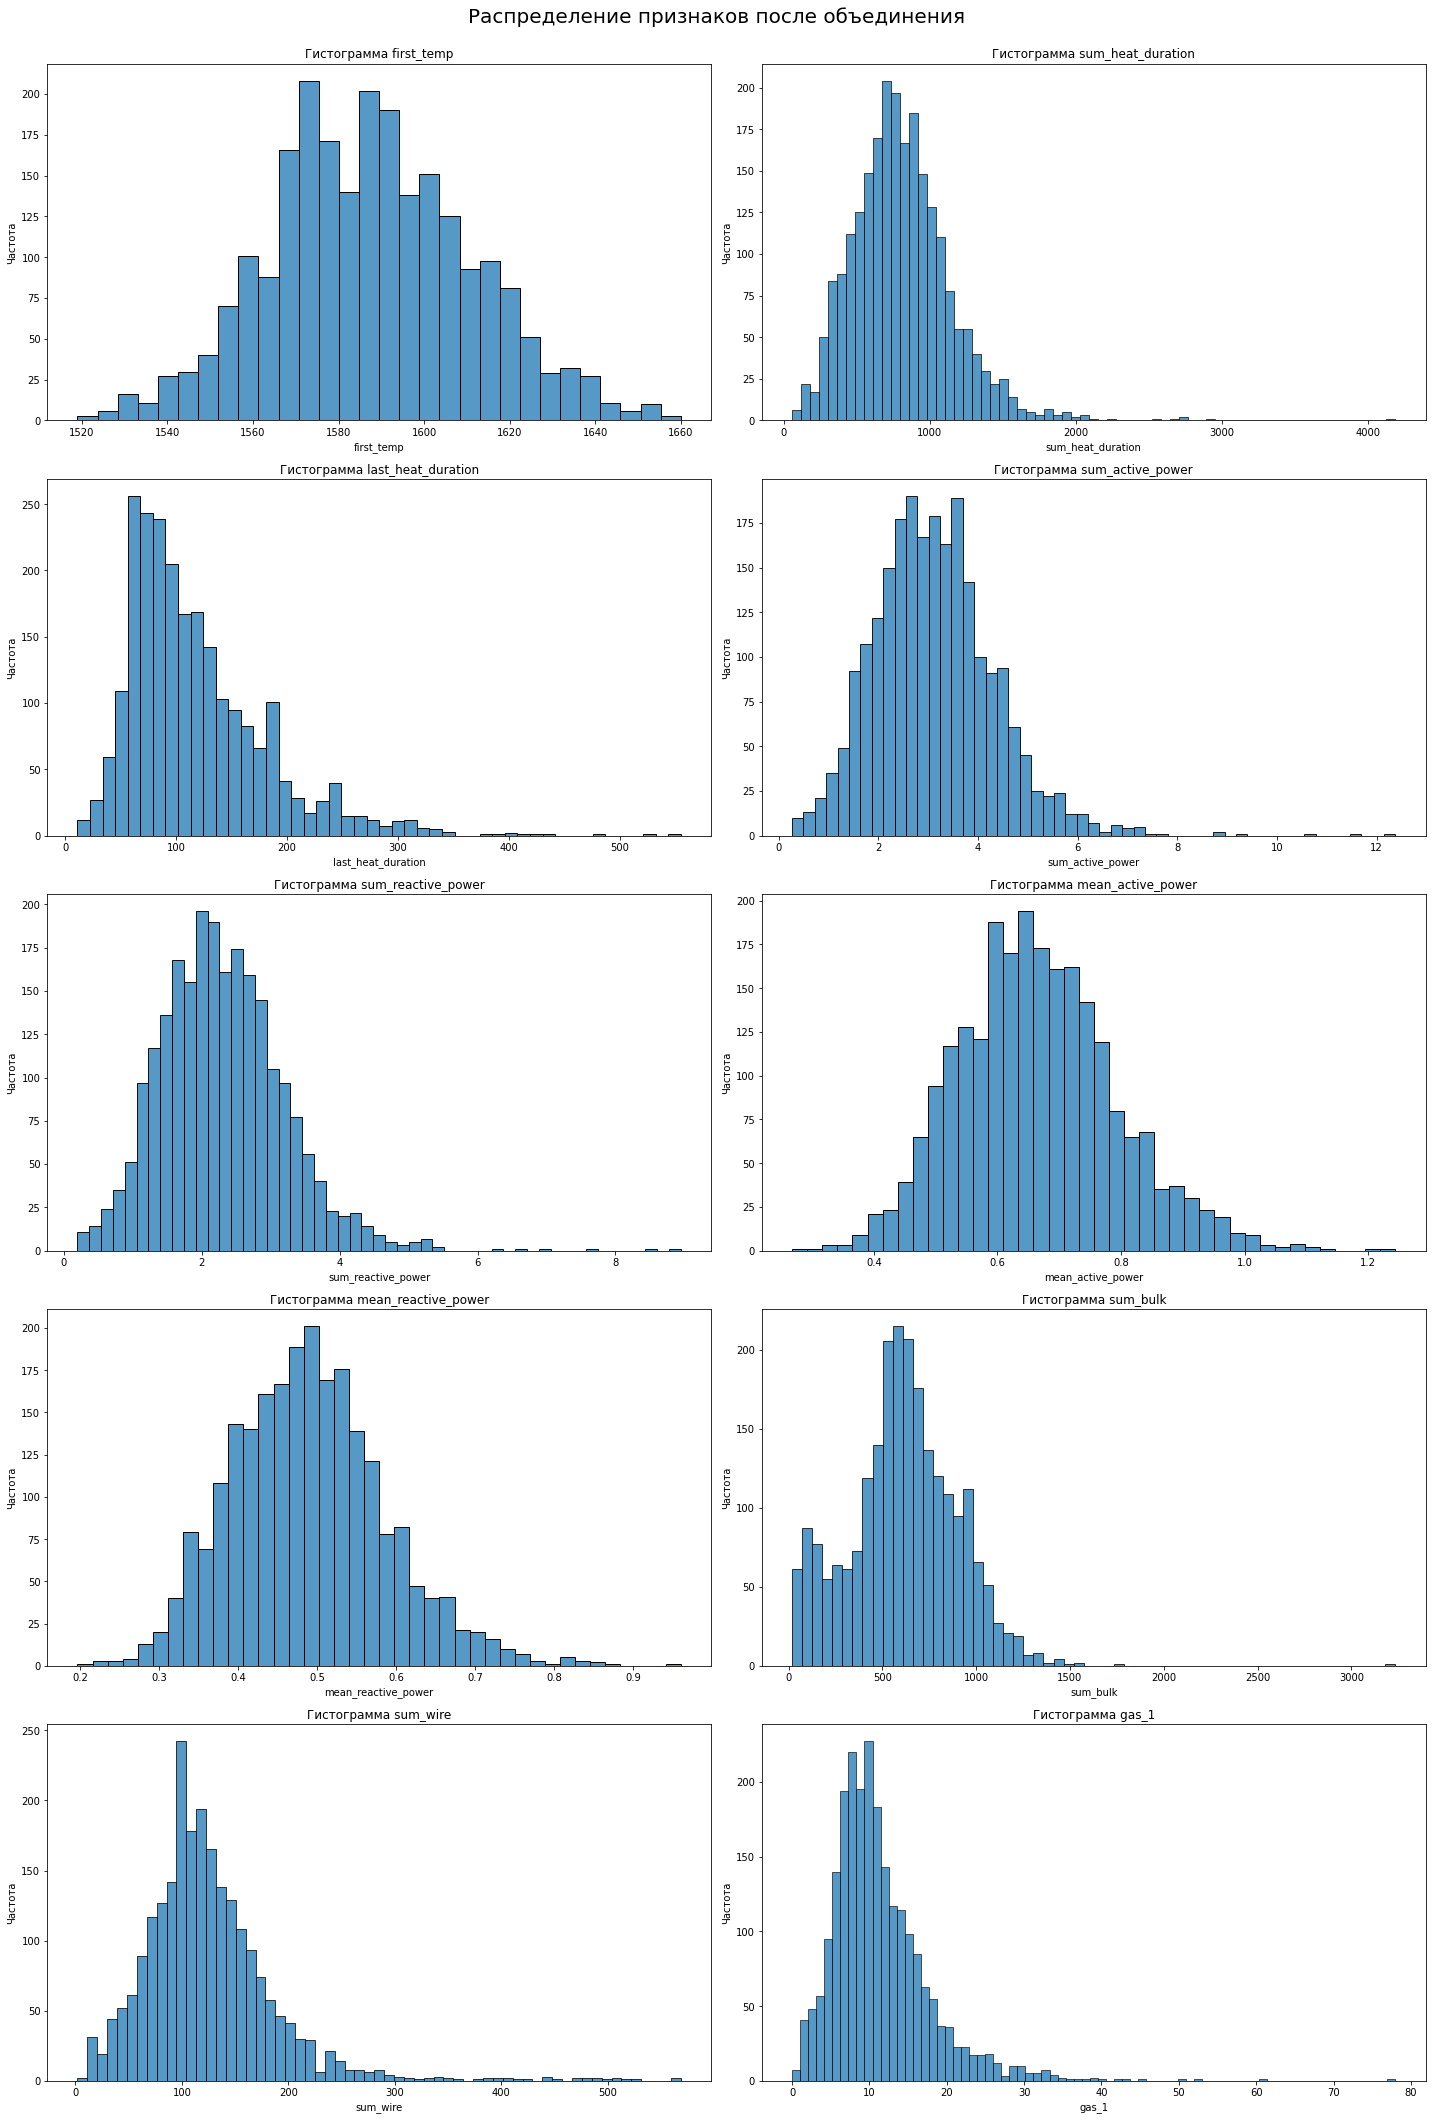

In [ ]:
cols = ['first_temp',
        'sum_heat_duration',
        'last_heat_duration',
        'sum_active_power',
        'sum_reactive_power',
        'mean_active_power',
        'mean_reactive_power',
        'sum_bulk',
        'sum_wire',
        'gas_1']

fig, ax = plt.subplots(5, 2, figsize=(20, 30))
ax = ax.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], ax=ax[i])
    ax[i].set_title(f'Гистограмма {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Частота')

fig.suptitle('Распределение признаков после объединения', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

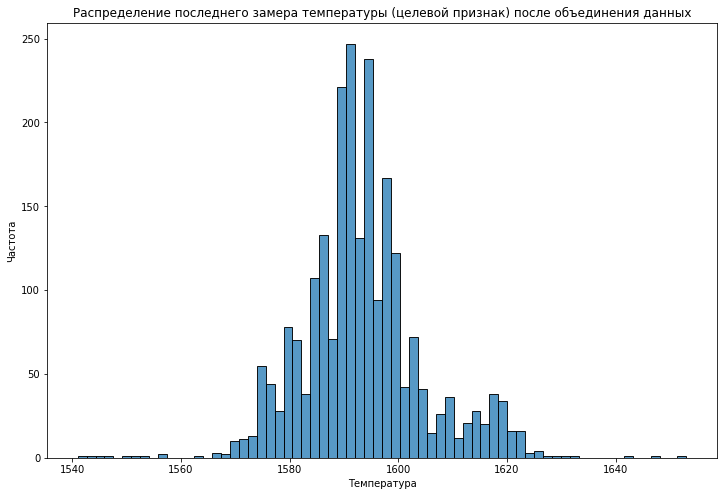

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df['last_temp'])
plt.title('Распределение последнего замера температуры (целевой признак) после объединения данных')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.show()

Также, построим диаграммы размаха:

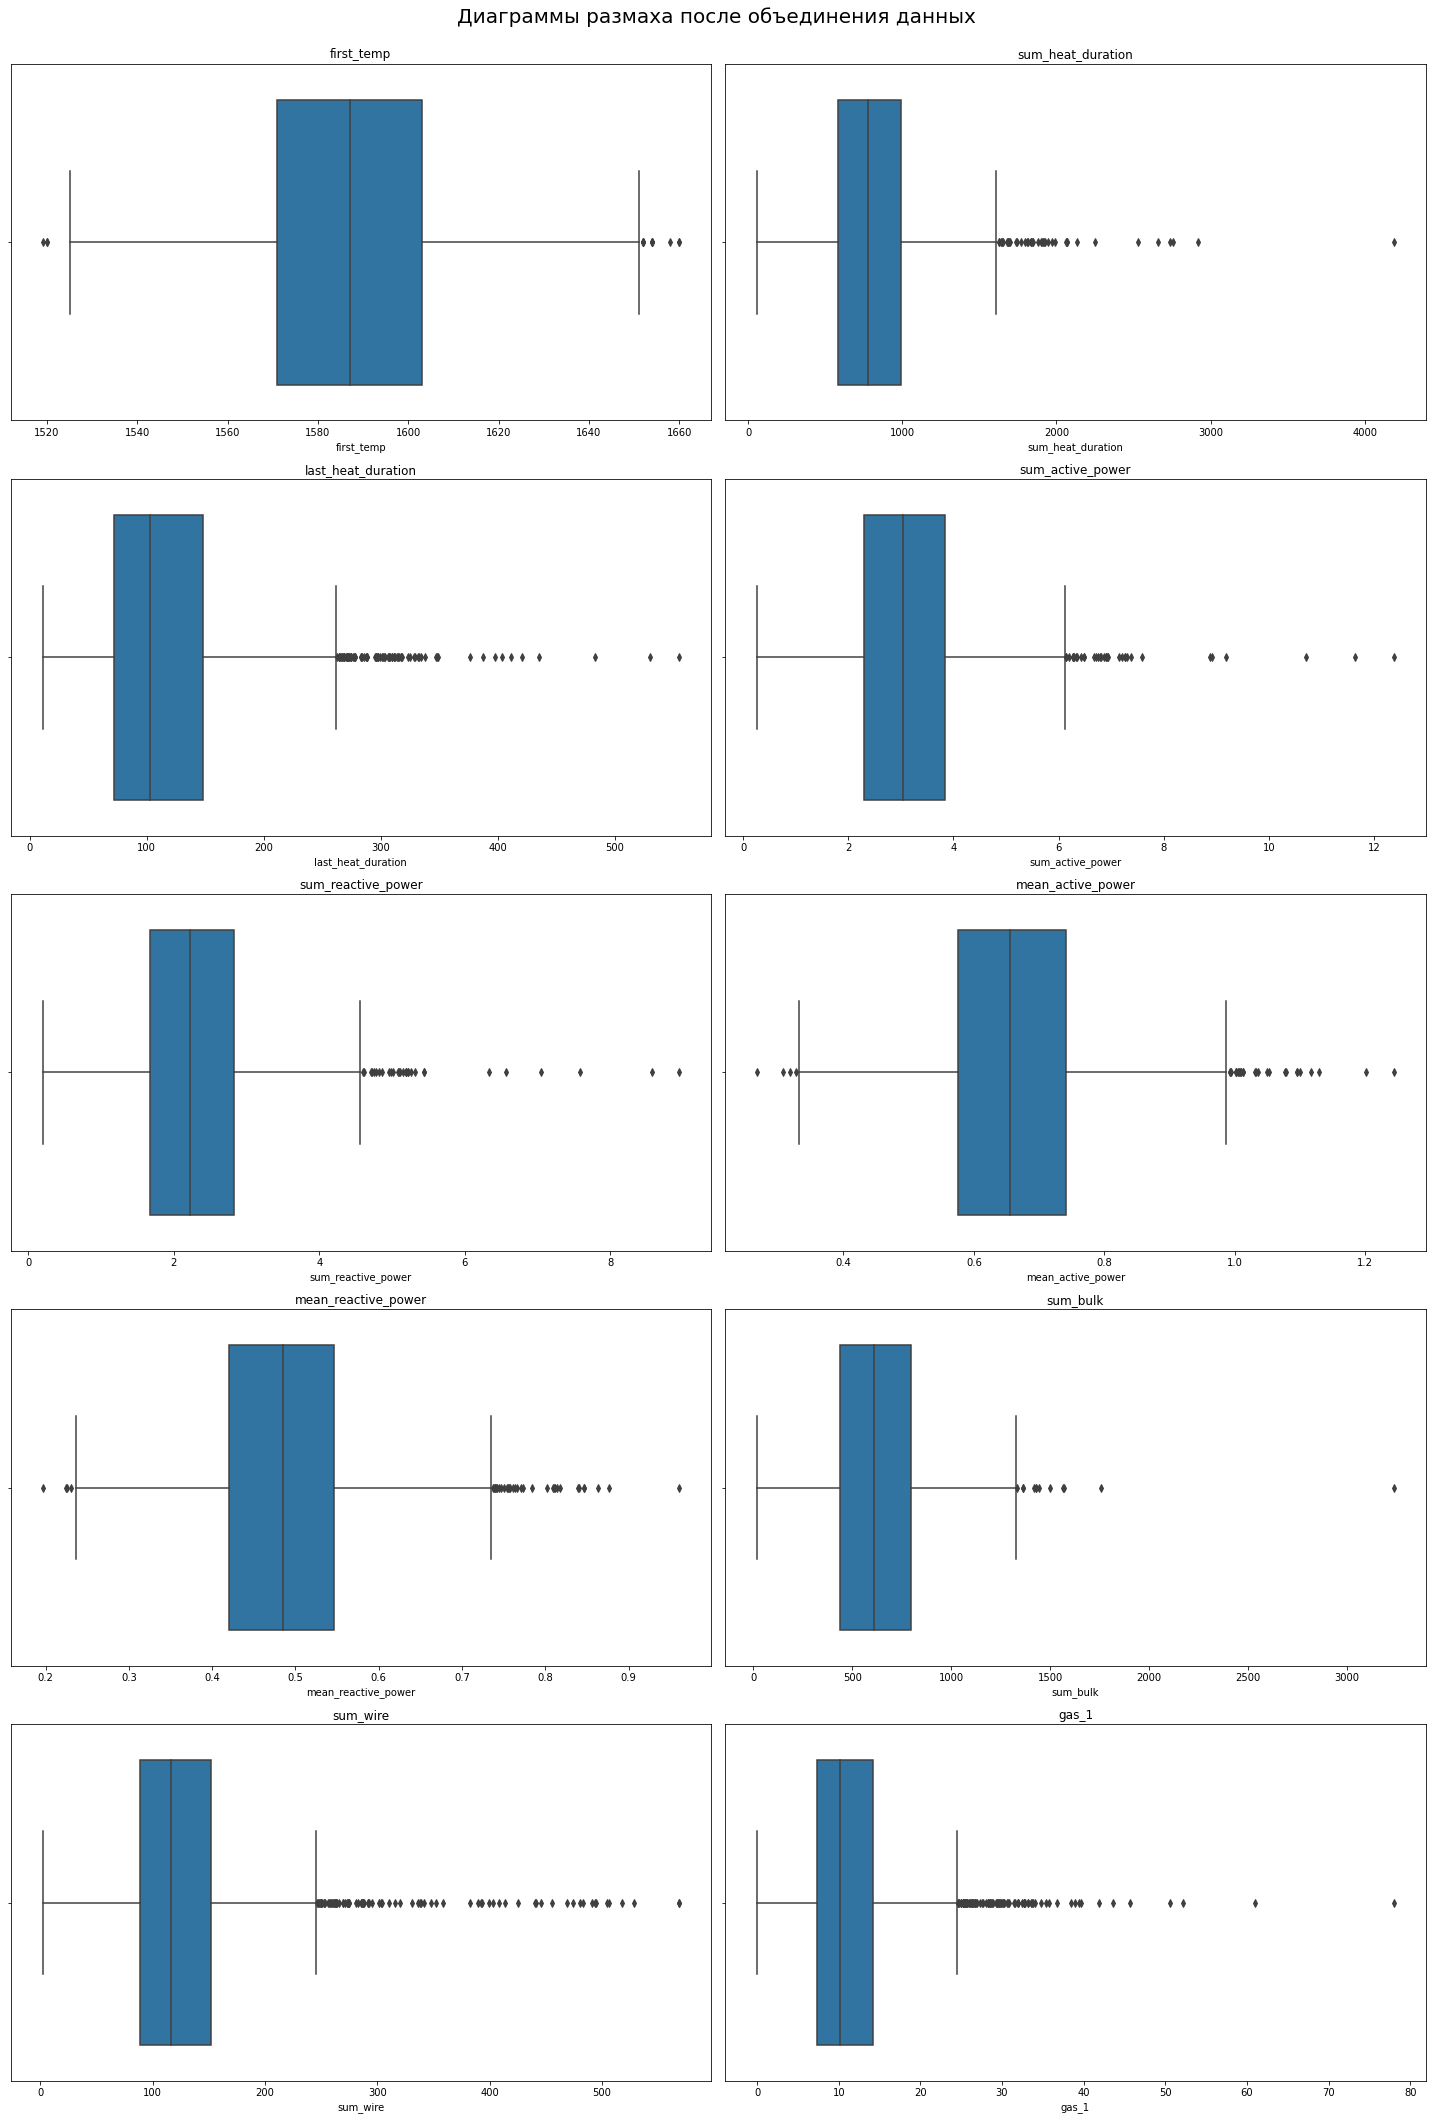

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
ax = ax.flatten()

for i, col in enumerate(cols):
    sns.boxplot(df[col], ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel(col)

fig.suptitle('Диаграммы размаха после объединения данных', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Распределения признаков не сильно изменились, они по-прежнему близки к нормальному и всё ещё содержат выбросы, однако аномальных значений не обнаружено.

In [ ]:
df.iloc[:,8:22].describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313
std,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [ ]:
df.iloc[:,23:31].describe()

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,102.423900,17.613213,3.241876,0.307209,0.980926,0.006374,0.311981,0.317795
std,43.540975,33.648176,27.972523,4.762842,8.702531,0.205926,4.407419,3.460248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,101.103600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,128.075222,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


Нулевых признаков среди `bulk_1` - `bulk_15`, `wire_1` - `wire_9` не обнаружено.

### Корреляционный анализ

Построим коррелограмму:

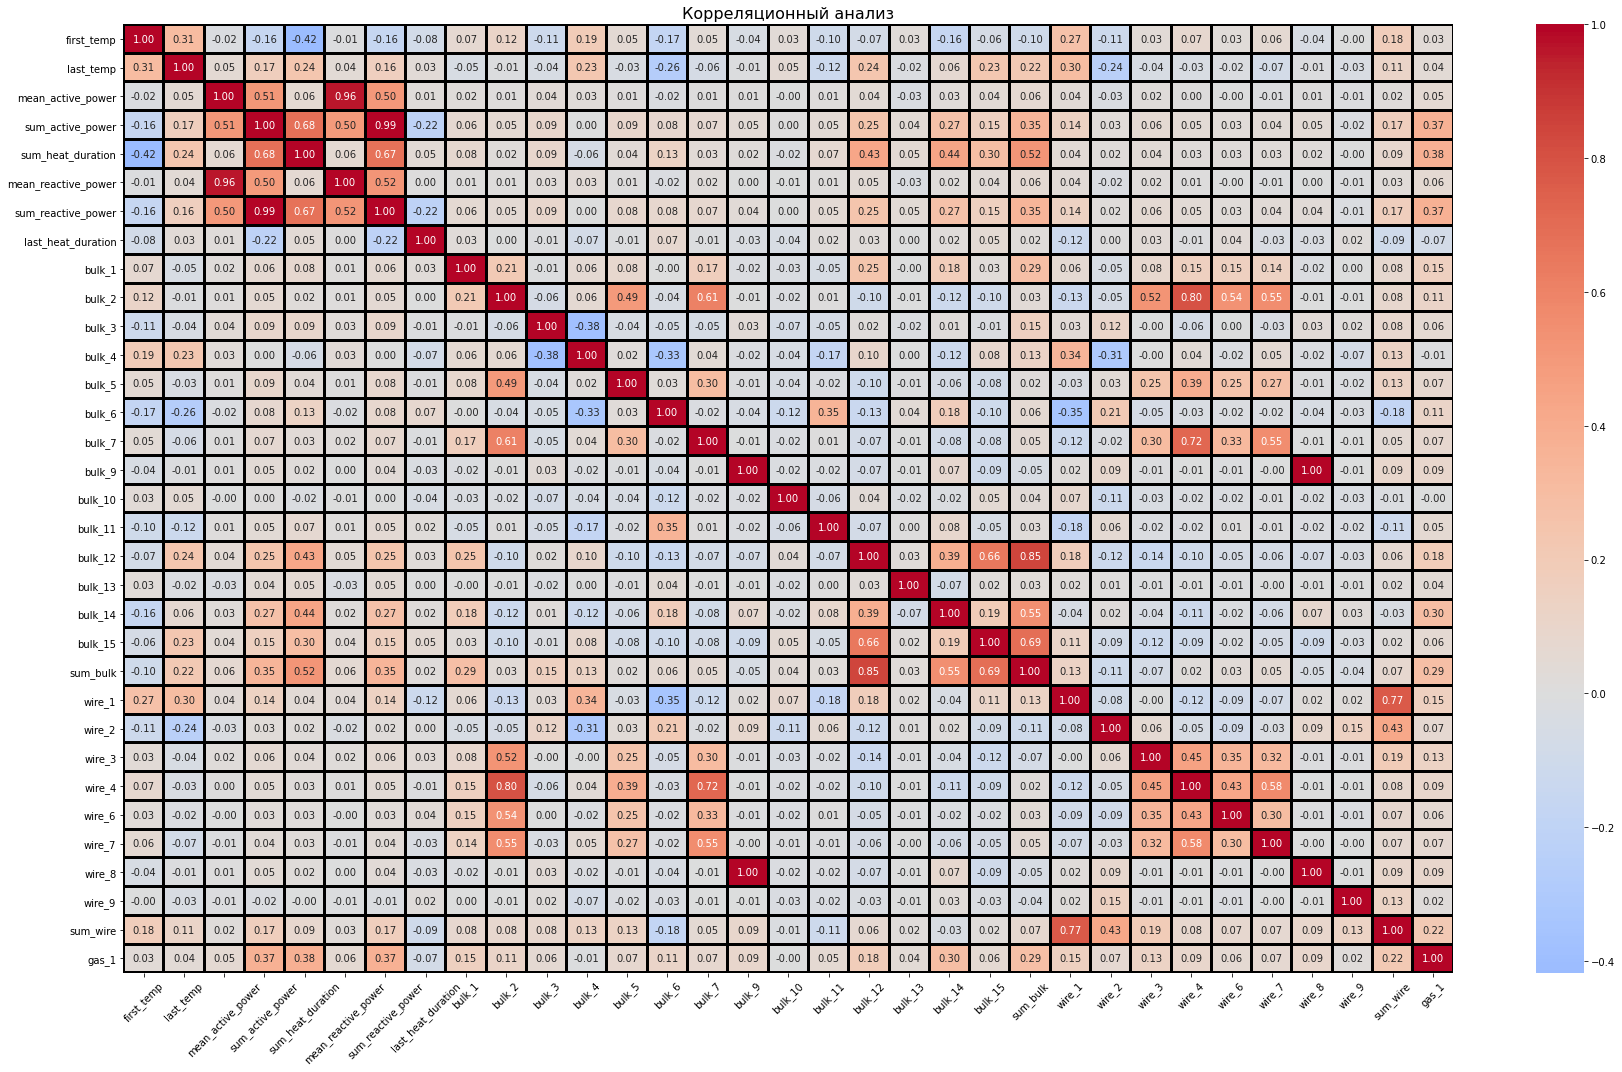

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(
    df.corr(method='spearman'),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=2,
    linecolor='black',
)

plt.title("Корреляционный анализ", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

Очевидна очень сильная линейная зависимость между суммарной активной и суммарной реактивной мощностью (0.99), между средней активной и средней реактивной (0.96), а также между объёмами материала `bulk_9` и `wire_8`, что свидетельствует о мультиколлинеарности. Избавимся от неё, удалив по одному признаку из пары: `sum_reactive_power`, `mean_reactive_power` и `bulk_8`.

In [ ]:
df = df.drop(columns=['sum_reactive_power',
                      'mean_reactive_power',
                      'bulk_9'])

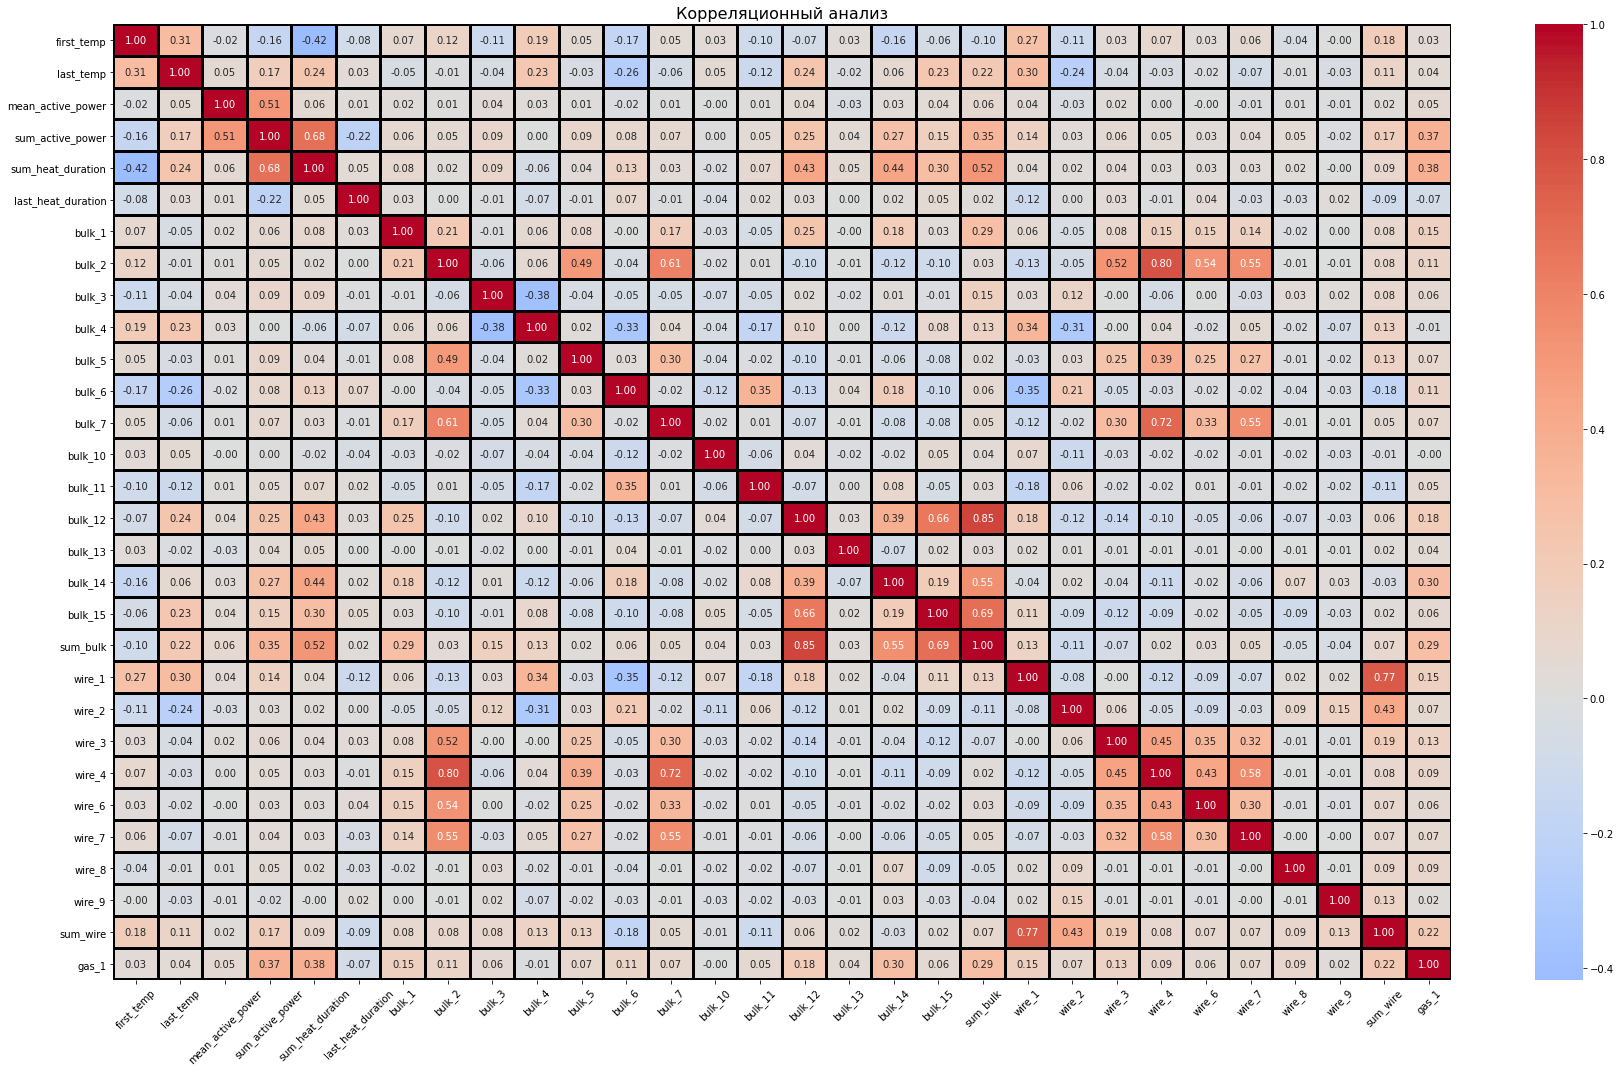

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(
    df.corr(method='spearman'),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=2,
    linecolor='black',
)

plt.title("Корреляционный анализ", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

### Промежуточный вывод

После объединения данных в один датафрейм признаки распределены адекватно, аномалий не обнаружено, пропущенных значений тоже. Корреляционный анализ показал наличие мультиколлинеарности, однако удалив признаки, образовывающие очень тесную линейную связь с другими признаками, удалось от неё избавиться.

## Обучение моделей

### Выделение обучающей и тестовой выборки

In [ ]:
df

,first_temp,last_temp,mean_active_power,sum_active_power,sum_heat_duration,last_heat_duration,bulk_1,bulk_2,bulk_3,bulk_4,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,sum_wire,gas_1
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,0.607346,3.036730,1098.0,148.0,0,0,0,43,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
2,1581,1602,0.534852,2.139408,811.0,210.0,0,0,0,73,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
3,1596,1599,0.812728,4.063641,655.0,65.0,0,0,0,34,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
4,1601,1625,0.676622,2.706489,741.0,278.0,0,0,0,81,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
5,1576,1602,0.563238,2.252950,869.0,71.0,0,0,0,78,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,0.792033,3.168133,723.0,99.0,0,0,21,0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,7.125735
2496,1554,1591,0.695820,4.174918,940.0,228.0,0,0,0,63,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,9.412616
2497,1571,1589,1.201746,3.605239,569.0,206.0,0,0,0,85,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,6.271699


In [ ]:
X = df.drop(columns='last_temp')
y = df['last_temp']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

### Формирование пайплайна

Для подбора оптимальной модели и гиперпараметров создадим пайплайн.  
На этапе препроцессинга достаточно масштабирования: будем перебирать StandardScaler(), MinMaxScaler() и рассмотрим вариант без масштабирования.  
Обучим такие модели как:  
- линейная регрессия,
- случайный лес,  
- CatBoost
- XGBoost.  

В качестве метрики качества используем MAE

In [ ]:
# Сформируем пайплайн
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', LinearRegression())
                 ])


# Зададим гиперпараметры
params = [{'scaler': ['passthrough',
                      StandardScaler(),
                      MinMaxScaler()
                      ],
           'model': [LinearRegression()]
           },

          {'scaler': ['passthrough',
                      StandardScaler(),
                      MinMaxScaler()
                      ],
           'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
           'model__max_depth': range(1, 31, 15),
           'model__min_samples_leaf': range(1, 32, 15),
           'model__min_samples_split': range(2, 33, 15),
           'model__n_estimators': [100]
           },

           {'scaler': ['passthrough'],
            'model': [CatBoostRegressor(iterations=1000,
                                        loss_function='MAE',
                                        eval_metric='MAE',
                                        early_stopping_rounds=100,
                                        random_state=RANDOM_STATE,
                                        verbose=400)],
            'model__iterations': [100, 500, 1000, 2000]
            },

            {'scaler': ['passthrough'],
            'model': [XGBRegressor(verbosity=0, random_state=RANDOM_STATE)],
             'model__learning_rate': [0.01, 0.25, 0.5],
             'model__n_estimators': [100, 200]
             }
         ]

### Обучение моделей

Будем использовать GridSearchCV для подбора оптимальных гиперпараметров

In [ ]:
grid = GridSearchCV(pipe,
                    params,
                    cv=5,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1
                    )

In [ ]:
grid.fit(X_train, y_train)

0:	learn: 8.0043462	total: 58.9ms	remaining: 5.83s
99:	learn: 5.7054021	total: 452ms	remaining: 0us
0:	learn: 7.8405873	total: 4.9ms	remaining: 485ms
99:	learn: 5.4554632	total: 395ms	remaining: 0us
0:	learn: 7.9793319	total: 4.68ms	remaining: 464ms
99:	learn: 5.6256375	total: 433ms	remaining: 0us
0:	learn: 7.9779703	total: 4.37ms	remaining: 433ms
99:	learn: 5.5944648	total: 420ms	remaining: 0us
0:	learn: 7.9549309	total: 5.92ms	remaining: 586ms
99:	learn: 5.7061155	total: 399ms	remaining: 0us
0:	learn: 8.0043462	total: 6.61ms	remaining: 3.3s
400:	learn: 4.2524290	total: 1.62s	remaining: 400ms
499:	learn: 3.9862224	total: 2.01s	remaining: 0us
0:	learn: 7.8405873	total: 4.05ms	remaining: 2.02s
400:	learn: 3.9964624	total: 1.59s	remaining: 393ms
499:	learn: 3.7197319	total: 1.98s	remaining: 0us
0:	learn: 7.9793319	total: 5.52ms	remaining: 2.76s
400:	learn: 4.0760048	total: 1.58s	remaining: 390ms
499:	learn: 3.7862761	total: 1.96s	remaining: 0us
0:	learn: 7.9779703	total: 4.37ms	remaining

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()],
                          'scaler': ['passthrough', StandardScaler(),
                                     MinMaxScaler()]},
                         {'model': [<catboost.core.CatBoostRegressor object at 0x7f8c82e13c70>],
                          'model__iterations': [100, 500, 1000, 2000],
                          'scaler': ['passthrough']}],
             scoring='neg_mean_absolute_error')

### Интерпретация результатов обучения

In [ ]:
print('Метрика MAE на обучающей выборке:', round(((-1)*grid.best_score_),2))

Метрика MAE на обучающей выборке: 6.11


In [ ]:
grid.best_params_

{'model': <catboost.core.CatBoostRegressor at 0x7f8c82e13c70>,
 'model__iterations': 2000,
 'scaler': 'passthrough'}

Лучшей оказалась модель CatBoostRegressor с гиперпараметром iterations = 2 000 без предварительного масштабирования данных. Посмотрим на значимость признаков:

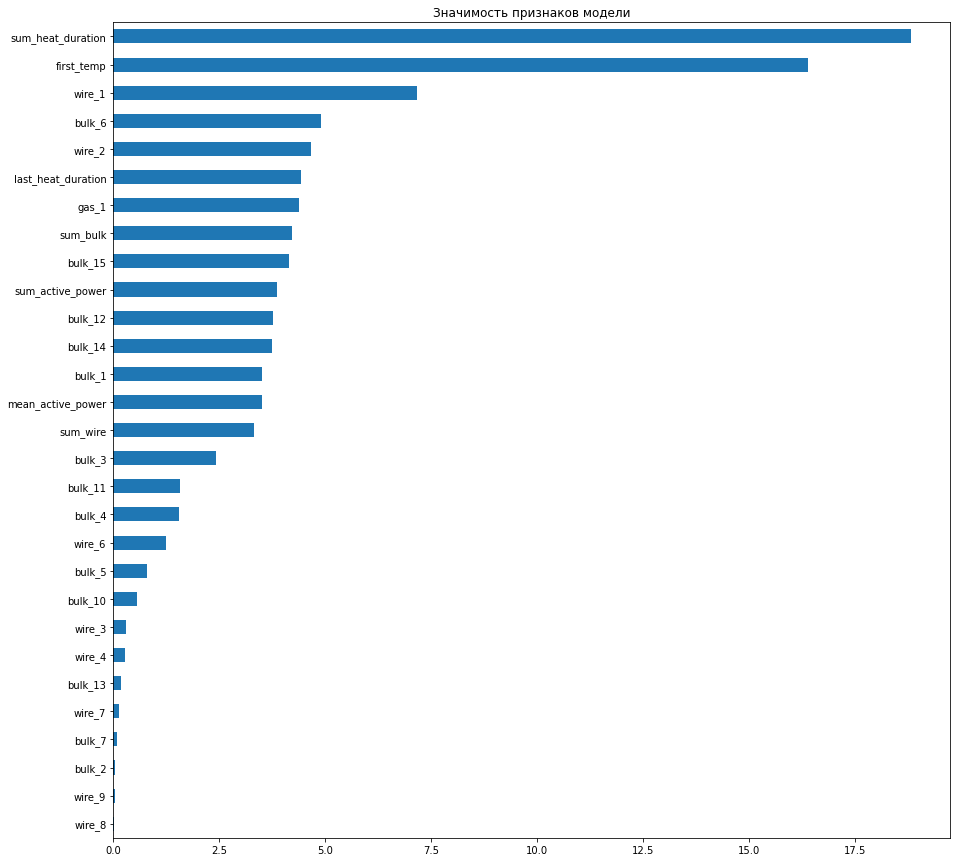

In [ ]:
scaler = grid.best_estimator_[0]
grid_model = grid.best_estimator_[1]

plt.figure(figsize=(15, 15))
feat_importances = pd.Series(grid_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Значимость признаков модели")
plt.show()

Наиболее значимыми признаками оказались:  
1. Суммарная длительность нагрева дугой;  
2. Первый замер температуры;  
3. Объём подачи проволочного материала `wire_1`.

## Тестирование оптимальной модели

In [ ]:
pipe_final = grid.best_estimator_

y_pred = pipe_final.predict(X_test)
print('Метрика MAE на тестовой выборке', round(mean_absolute_error(y_test, y_pred), 2))

Метрика MAE на тестовой выборке 6.06


Достигнут необходимый критерий качества модели (`MAE <= 6.8`) на тестовой выборке

## Общий вывод

В ходе работы над проектом была обучена модель для прогнозирования температуры сплава на стадии обработки стали.

На этапе **предобработки данных** были выявлены и устранены такие проблемы, как:  
- несогласованность и неудобство названий столбцов датасета,  
- пропущенные значения,  
- некорректные типы данных.  

В ходе **исследовательского анализа данных**:  
- были обработаны аномальные значения,  
- удалены неинформативные признаки,  
- получено представление о распределении данных: признаки по большей части имеют распределение, близкое к нормальному, содержат выбросы (но они находятся в пределах допустимых значений, поэтому было решено оставить их без изменений, чтобы модель обучалась на разных данных и могла учитывать разные случаи).

Затем была выполнена **подготовка данных**:
- созданы дополнительные признаки,  
- все данные объединены в один датафрейм,  
- выполнен повторный исследовательский анализ,  
- проведён корреляционный анализ,  
- выявлена и устранена мультиколлнеарность.  


На этапе **обучения** с помощью `GridSearchCV` была подобрана оптимальная модель и гиперпараметры, а также проинтерпретированы результаты обучения.

Рассматривались такие модели как:
- `LinearRegression()`;
- `RandomForestRegressor()`;  
- `CatBoostRegressor()`;  
- `XGBRegressor()`.

**Лучший результат** показала `CatBoostRegressor` с гиперпараметром `iterations = 2 000` без предварительного масштабирования данных.

Наиболее значимыми признаками оказались:  
1. Суммарная длительность нагрева дугой;  
2. Первый замер температуры;  
3. Объём подачи проволочного материала `wire_1`.  
Также значимы, но с меньшими коэффициентами:
4. Объём подачи сыпучего материала `bulk_6`;  
5. Объём подачи проволочного материала `wire_2`;  
6. Длительность последнего нагрева дугой;  
7. Объём подаваемого газа;  
8. Суммарный объём сыпучих материалов.

Метрика качества `MAE` на обучающем наборе данных составила **6.11** на тестовой выборке **6.06** (критерий качества: MAE <= 6.8)